## Import packages

In [1]:
import pandas
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec

color = ["#1f78b4", "#599d7A", "#D79B00", "#9673A6", "#d93b43"]


## Load dataset

In [ ]:
df = pandas.read_pickle('diffusion.pckl.gzip', compression='gzip')
excluded = ["atoms", "D_300K", "formula", "structure", "composition", "log_conductivity", "Ea", "D_sim", "D0", "r", "logD", "atoms_diffusion", "diffusion_temps", "Na_former_ratio", "Na_anion_ratio", "D_sim_std", "Na_spacing"]
X = df.drop(excluded, axis=1)

## Plotting function

In [14]:
def plot_model(reg_model, dataset, mode="D", axes=None):
    min_val = np.min([np.min(dataset[2]), np.min(dataset[3]), np.min(reg_model.predict(dataset[0])), np.min(reg_model.predict(dataset[1]))]) - 1
    max_val = np.max([np.max(dataset[2]), np.max(dataset[3]), np.max(reg_model.predict(dataset[0])), np.max(reg_model.predict(dataset[1]))]) + 1

    # Prediction plot
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax = axes[0]
    ax.scatter(dataset[2], reg_model.predict(dataset[0]), label="Train", color=color[0], edgecolor='k', s=30, alpha=0.8, linewidths=0.5)
    ax.scatter(dataset[3], reg_model.predict(dataset[1]), label="Test", color=color[-1], edgecolor='k', s=30, alpha=0.8, linewidths=0.5)
    ax.plot([min_val, max_val], [min_val, max_val], color="k")
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='both', which='major', labelsize=11)

    if mode == "D":
        ax.set_ylabel("Predicted ln($D_{Na}$) (cm$^2$ s$^{-1}$)", fontsize=12)
        ax.set_xlabel("Simulated ln($D_{Na}$) (cm$^2$ s$^{-1}$)", fontsize=12)
    elif mode == "cond":
        ax.set_ylabel("Predicted ln($\sigma_{Na}$) (S/m)", fontsize=12)
        ax.set_xlabel("Simulated ln($\sigma_{Na}$) (S/m)", fontsize=12)

    ax.text(0.53, 0.13, 'Train R$^2$ = ' + str(round(reg_model.score(dataset[0], dataset[2]), 3)), transform=ax.transAxes, ha='left', va='center', fontsize=12, color="k")
    ax.text(0.53, 0.06, 'Test R$^2$ = ' + str(round(reg_model.score(dataset[1], dataset[3]), 3)), transform=ax.transAxes, ha='left', va='center', fontsize=12, color="k")
    ax.legend(frameon=False, fontsize=12)

    try:
    # Feature importances
        ax = axes[1]
        importances = reg_model.feature_importances_
        included = X.columns.values
        indices = np.argsort(importances)[::-1]

        label_map = {'density': r'$\rho$', 'weighted_electronegativity': r'$\bar{X}$'}
        readable_included = np.array([label_map.get(label, label) for label in included])
        
        ax.barh(readable_included[indices][0:10][::-1], importances[indices][0:10][::-1], color=color[0])
        ax.set_xlabel("Feature Importance", fontsize=12)
        ax.set_ylabel("Features", fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=11)
    except:
        pass

## Linear Model

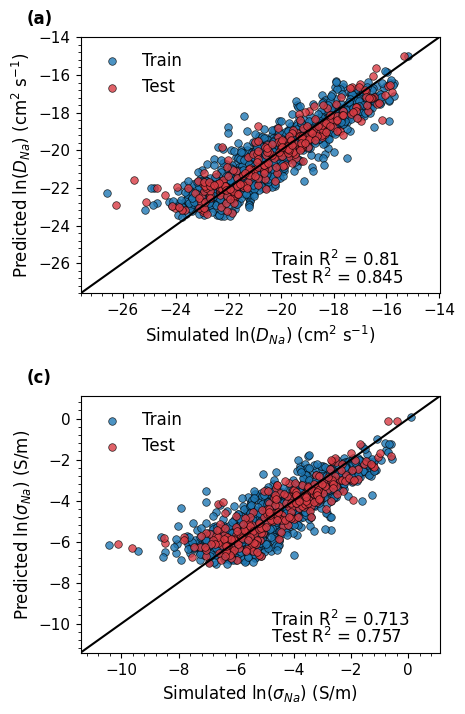

In [15]:
def fit_lin_model(X, y):
    dataset = train_test_split(X, y, test_size=0.2, random_state=1)
    lin_reg = LinearRegression()
    lin_reg.fit(dataset[0], dataset[2])
    return lin_reg, dataset

# Create figure and custom GridSpec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Assign axes with uneven widths
ax00 = fig.add_subplot(gs[0, 0])  # Prediction plot for y1
ax10 = fig.add_subplot(gs[1, 0])  # Prediction plot for y2

ax00.text(-0.15, 1.05, "(a)", transform=ax00.transAxes, fontsize=12, fontweight='bold')
ax10.text(-0.15, 1.05, "(c)", transform=ax10.transAxes, fontsize=12, fontweight='bold')

y1 = [np.log(d) for d in df["D_300K"]]
y2 = df["log_conductivity"]

# Use fit_plot with specific axes
lin_reg, lin_dataset = fit_lin_model(X, y1)
plot_model(lin_reg, lin_dataset, mode="D", axes=[ax00])
lin_reg, lin_dataset = fit_lin_model(X, y2)
plot_model(lin_reg, lin_dataset, mode="cond", axes=[ax10])

plt.show()


## Random Forest Model

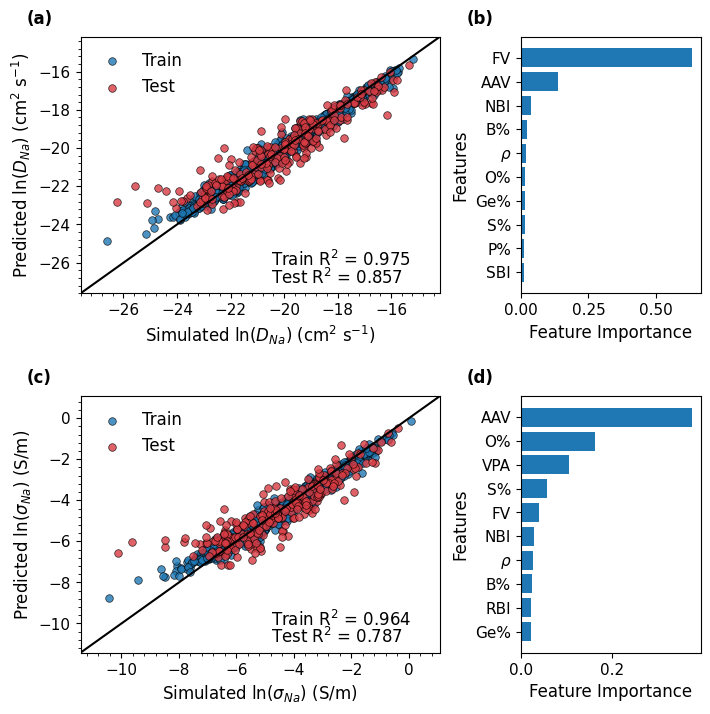

In [16]:
def fit_rf_model(X, y):
    dataset = train_test_split(X, y, test_size=0.2, random_state=1)
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
    rf_reg.fit(dataset[0], dataset[2])
    return rf_reg, dataset

# Create figure and custom GridSpec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Assign axes with uneven widths
ax00 = fig.add_subplot(gs[0, 0])  # Prediction plot for y1
ax01 = fig.add_subplot(gs[0, 1])  # Feature importance plot for y1
ax10 = fig.add_subplot(gs[1, 0])  # Prediction plot for y2
ax11 = fig.add_subplot(gs[1, 1])  # Feature importance plot for y2

ax00.text(-0.15, 1.05, "(a)", transform=ax00.transAxes, fontsize=12, fontweight='bold')
ax01.text(-0.30, 1.05, "(b)", transform=ax01.transAxes, fontsize=12, fontweight='bold')
ax10.text(-0.15, 1.05, "(c)", transform=ax10.transAxes, fontsize=12, fontweight='bold')
ax11.text(-0.30, 1.05, "(d)", transform=ax11.transAxes, fontsize=12, fontweight='bold')

y1 = [np.log(d) for d in df["D_300K"]]
y2 = df["log_conductivity"]

# Use fit_plot with specific axes
rf_reg, rf_dataset = fit_rf_model(X, y1)
plot_model(rf_reg, rf_dataset, mode="D", axes=[ax00, ax01])
rf_reg, rf_dataset = fit_rf_model(X, y2)
plot_model(rf_reg, rf_dataset, mode="cond", axes=[ax10, ax11])

plt.show()

## Exclude composition features

In [20]:
excluded = ["atoms", "D_300K", "formula", "structure", "composition", "log_conductivity", "Ea", "D_sim", "D0", "r", "logD",  "atoms_diffusion", "diffusion_temps", "Na_former_ratio", "Na_anion_ratio", "D_sim_std", "Na_spacing", 'B%', 'N%', 'O%', 'F%', 'Na%', 'Al%', 'Si%', 'P%', 'S%',
       'Cl%', 'Ge%', 'Br%', 'I%']
X = df.drop(excluded, axis=1)

In [21]:
def fit_rf_model(X, y):
    dataset = train_test_split(X, y, test_size=0.2, random_state=1)
    rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
    rf_reg.fit(dataset[0], dataset[2])
    return rf_reg, dataset

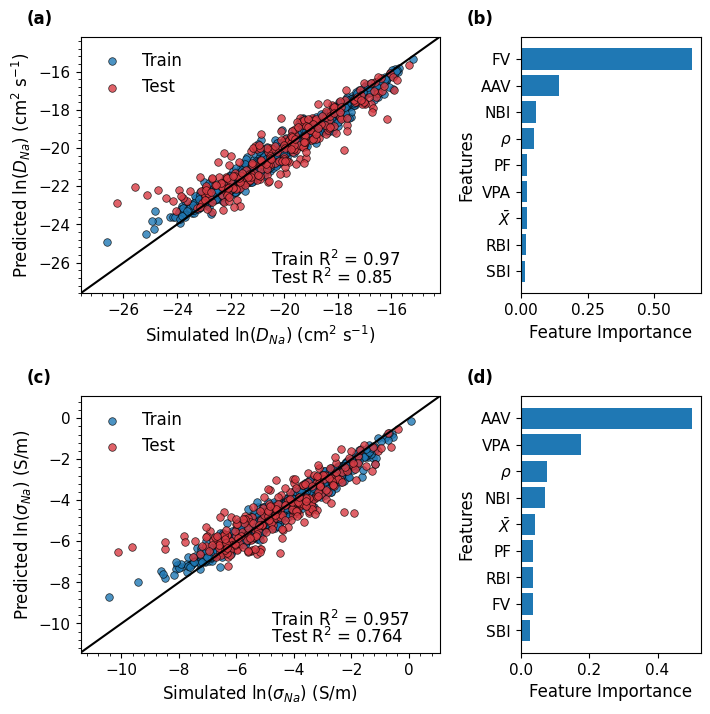

In [22]:
# Create figure and custom GridSpec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Assign axes with uneven widths
ax00 = fig.add_subplot(gs[0, 0])  # Prediction plot for y1
ax01 = fig.add_subplot(gs[0, 1])  # Feature importance plot for y1
ax10 = fig.add_subplot(gs[1, 0])  # Prediction plot for y2
ax11 = fig.add_subplot(gs[1, 1])  # Feature importance plot for y2

ax00.text(-0.15, 1.05, "(a)", transform=ax00.transAxes, fontsize=12, fontweight='bold')
ax01.text(-0.30, 1.05, "(b)", transform=ax01.transAxes, fontsize=12, fontweight='bold')
ax10.text(-0.15, 1.05, "(c)", transform=ax10.transAxes, fontsize=12, fontweight='bold')
ax11.text(-0.30, 1.05, "(d)", transform=ax11.transAxes, fontsize=12, fontweight='bold')

y1 = [np.log(d) for d in df["D_300K"]]
y2 = df["log_conductivity"]

# Use fit_plot with specific axes
rf_reg, rf_dataset = fit_rf_model(X, y1)
plot_model(rf_reg, rf_dataset, mode="D", axes=[ax00, ax01])
rf_reg, rf_dataset = fit_rf_model(X, y2)
plot_model(rf_reg, rf_dataset, mode="cond", axes=[ax10, ax11])

plt.show()